<a href="https://colab.research.google.com/github/sourcecode369/Kaggle-Kernels/blob/master/Severstal_Steel_Defect_Detection/Severstal_Steel_Defect_Detection_Clear_Mask_Vizualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"rhtsingh","key":"05e5c425aae6dfba32a031192446751a"}'}

In [0]:
!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle competitions download -c severstal-steel-defect-detection

 72% 5.00M/6.91M [00:00<00:00, 50.9MB/s]
100% 6.91M/6.91M [00:00<00:00, 63.6MB/s]
  0% 0.00/141k [00:00<?, ?B/s]
100% 141k/141k [00:00<00:00, 143MB/s]
 99% 1.15G/1.16G [00:12<00:00, 90.4MB/s]
100% 1.16G/1.16G [00:12<00:00, 96.5MB/s]
 95% 122M/129M [00:01<00:00, 103MB/s] 
100% 129M/129M [00:01<00:00, 98.7MB/s]


In [5]:
!ls

sample_data	       test_images.zip	train_images.zip
sample_submission.csv  train.csv.zip


In [6]:
!unzip test_images.zip 
!rm -rf test_images.zip
!unzip train_images.zip 
!rm -rf train_images.zip
!unzip train.csv.zip 
!rm -rf train.csv.zip

Archive:  test_images.zip
  inflating: 1804f41eb.jpg           
  inflating: c90f155dd.jpg           
  inflating: e0b422958.jpg           
  inflating: a631d53aa.jpg           
  inflating: d01da361f.jpg           
  inflating: 86fe3cf8c.jpg           
  inflating: 54eb4b690.jpg           
  inflating: 2efa6b22f.jpg           
  inflating: d6128fbfc.jpg           
  inflating: f625f93a1.jpg           
  inflating: 499a9893b.jpg           
  inflating: 4c5671c92.jpg           
  inflating: f05581eef.jpg           
  inflating: d04a7fb6c.jpg           
  inflating: 7dd388867.jpg           
  inflating: 7dd7fc396.jpg           
  inflating: 2a830069f.jpg           
  inflating: 44d86ff71.jpg           
  inflating: 6d29df253.jpg           
  inflating: c86f91dbf.jpg           
  inflating: 674ecec48.jpg           
  inflating: 541e5bfec.jpg           
  inflating: 67fd6ce4d.jpg           
  inflating: 9d81c8973.jpg           
  inflating: d89072b2f.jpg           
  inflating: 443d3ddd0.j

In [7]:
%%time
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import os
os.environ["PYTHONHASHSEED"] = str(1)
import gc
gc.enable()

import urllib 
import zipfile 
import tarfile 
import functools 
import itertools 
from PIL import Image 
from tqdm import tqdm 
from pathlib import Path

import cv2
import numpy as np
np.set_printoptions(precision=2)
import pandas as pd
pd.option_context("display.maxrows",100)
import matplotlib.pyplot as plt 
import seaborn as sns
%config InlineBackend.figure_format = "retina"
sns.set_style("whitegrid")
sns.set(rc={"figure.figsize":(12,10)})

from collections import defaultdict, Counter

import warnings 
warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")

import logging
logger = logging.getLogger()
logging.debug(logger)

CPU times: user 317 ms, sys: 55.3 ms, total: 373 ms
Wall time: 696 ms


In [0]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("sample_submission.csv")

In [9]:
print(train_df.shape)
train_df.head()

(50272, 2)


,ImageId_ClassId,EncodedPixels
0,0002cc93b.jpg_1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0002cc93b.jpg_2,NaN
2,0002cc93b.jpg_3,NaN
3,0002cc93b.jpg_4,NaN
4,00031f466.jpg_1,NaN


In [10]:
print(test_df.shape)
test_df.head()

(7204, 2)


,ImageId_ClassId,EncodedPixels
0,004f40c73.jpg_1,1 1
1,004f40c73.jpg_2,1 1
2,004f40c73.jpg_3,1 1
3,004f40c73.jpg_4,1 1
4,006f39c41.jpg_1,1 1


In [0]:
class_dict = defaultdict(int)
kind_class_dict = defaultdict(int)

no_defects_num = 0
defects_num = 0

for col in range(0,train_df.shape[0],4):
  img_names = [str(i).split("_")[0] for i in train_df.iloc[col:col+4, 0]]
  
  if not (img_names[0] == img_names[1] == img_names[2] == img_names[3]):
    raise ValueError 
  labels = train_df.iloc[col:col+4, 1]
  if labels.isna().all():
    no_defects_num += 1
  else:
    defects_num += 1

  kind_class_dict[sum(labels.isna().values == False)] += 1

  for idx, label in enumerate(labels.isna().values.tolist()):
    if label == False:
      class_dict[idx+1] += 1

In [12]:
class_dict

defaultdict(int, {1: 897, 2: 247, 3: 5150, 4: 801})

In [13]:
kind_class_dict

defaultdict(int, {0: 5902, 1: 6239, 2: 425, 3: 2})

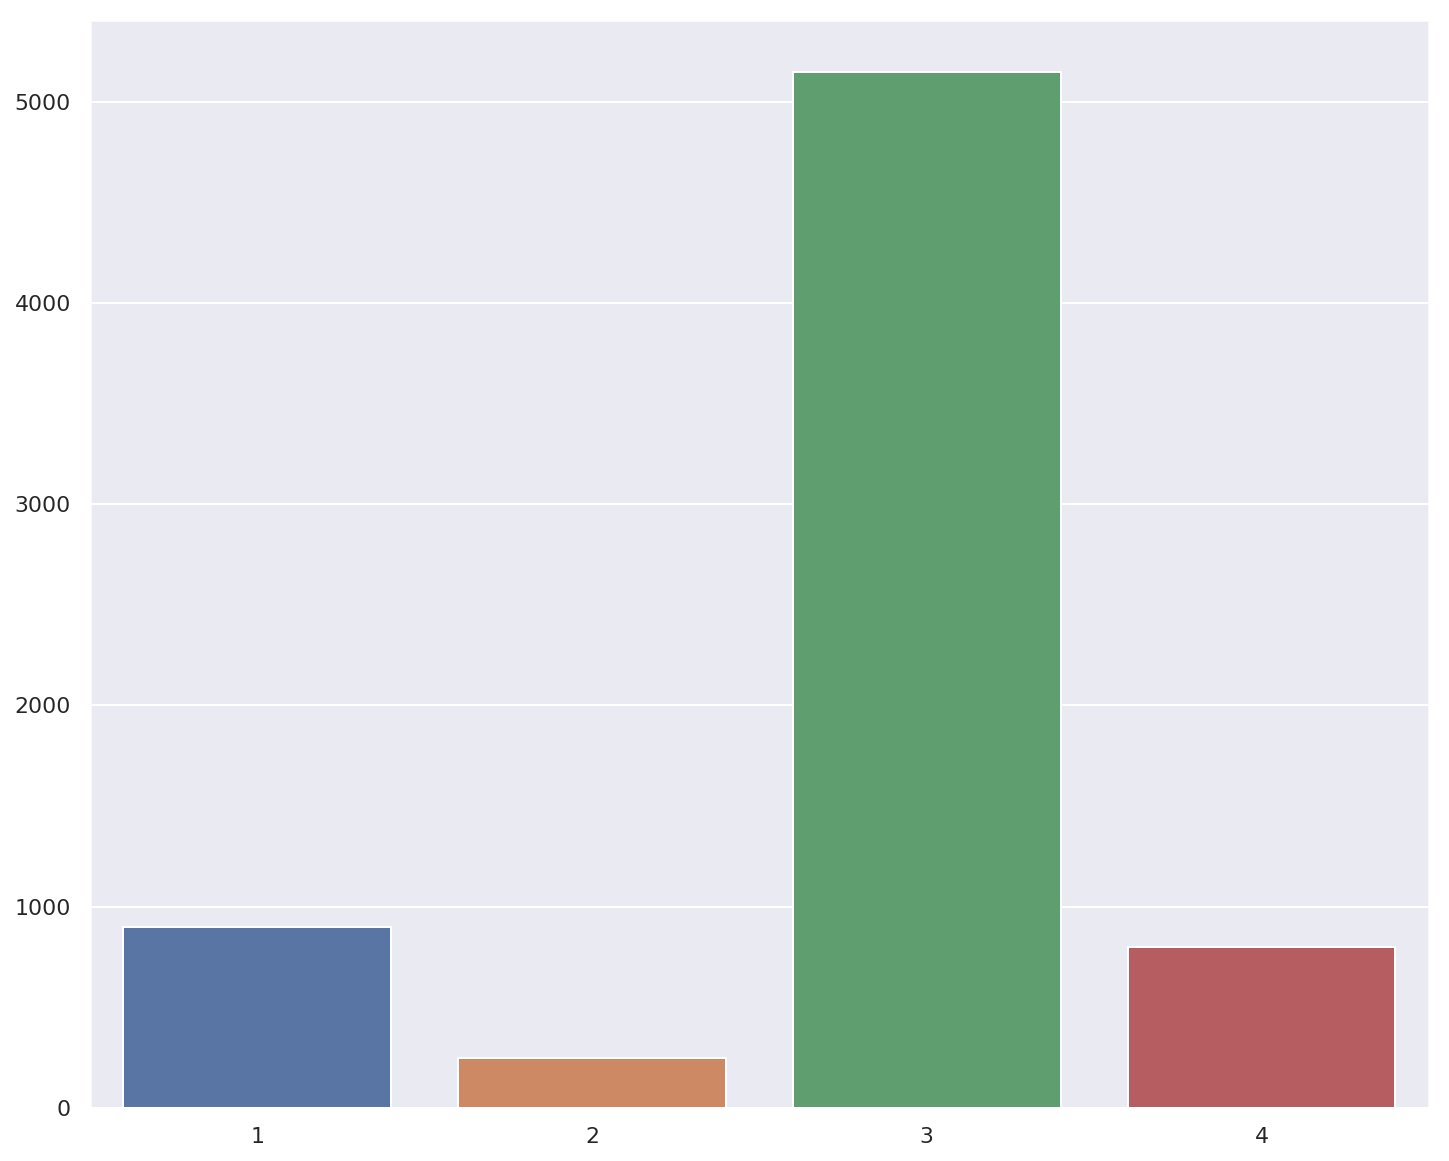

In [14]:
sns.barplot(x=list(class_dict.keys()), y=list(class_dict.values()) )

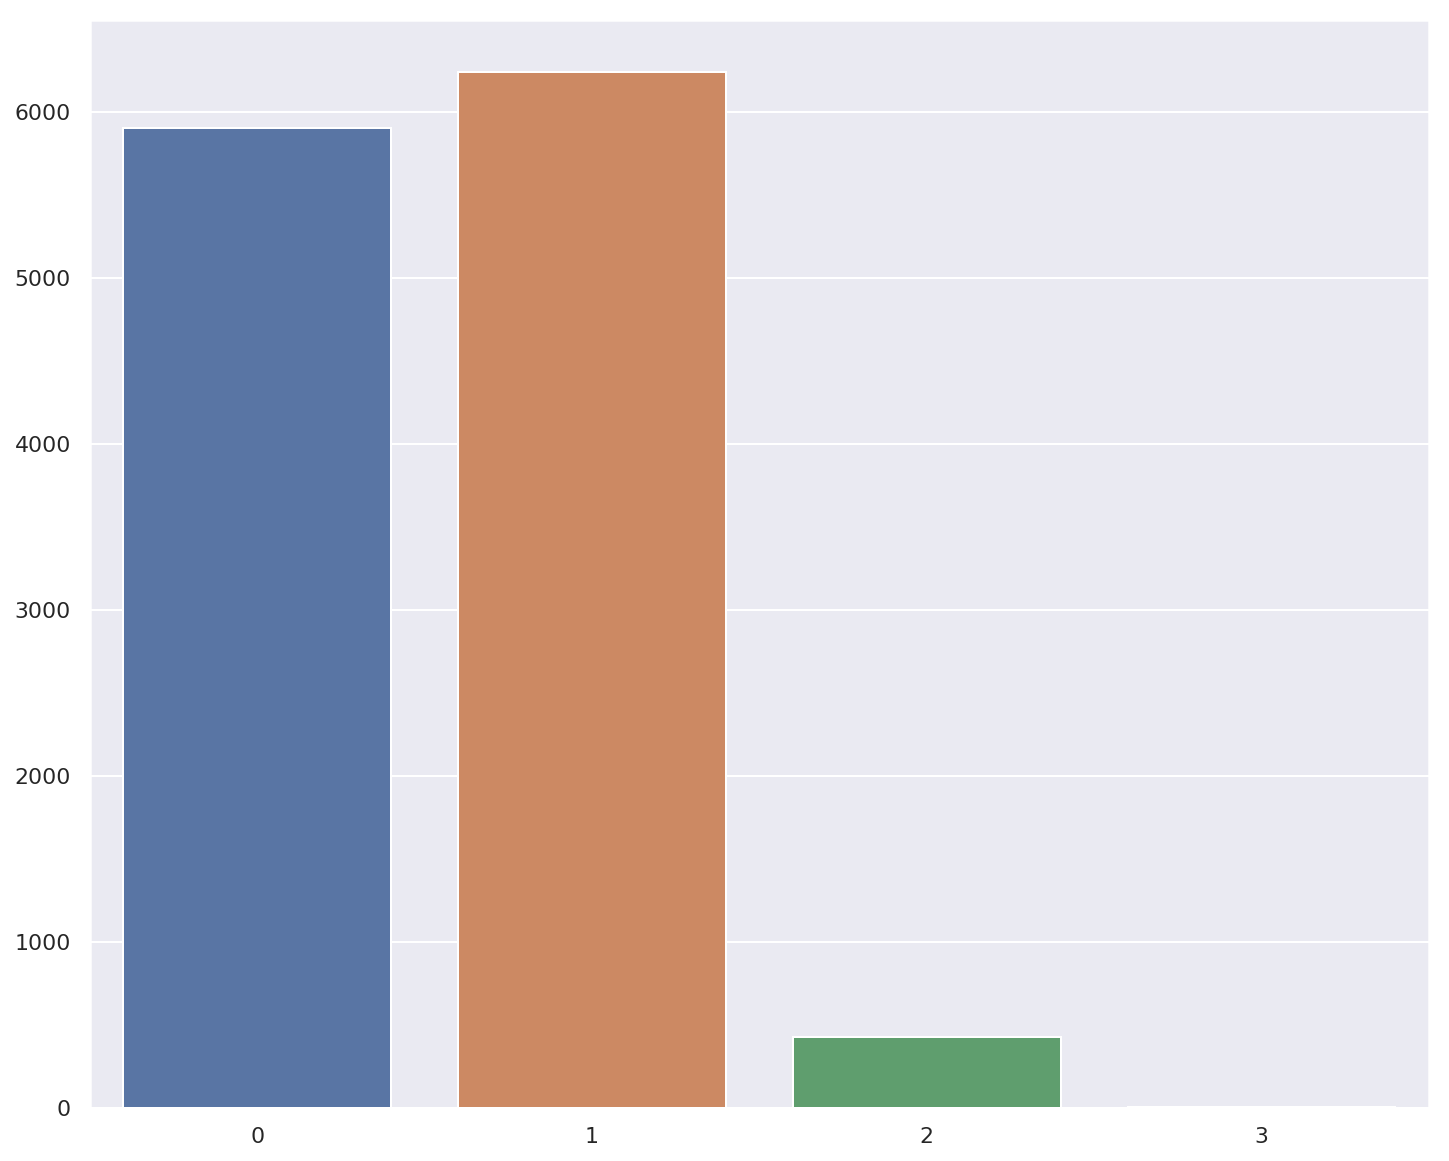

In [15]:
sns.barplot(x=list(kind_class_dict.keys()), y=list(kind_class_dict.values()) )

In [16]:
train_df["ImageId"] = train_df.ImageId_ClassId.apply(lambda x: x.split("_")[0])
train_df.head()

,ImageId_ClassId,EncodedPixels,ImageId
0,0002cc93b.jpg_1,29102 12 29346 24 29602 24 29858 24 30114 24 3...,0002cc93b.jpg
1,0002cc93b.jpg_2,NaN,0002cc93b.jpg
2,0002cc93b.jpg_3,NaN,0002cc93b.jpg
3,0002cc93b.jpg_4,NaN,0002cc93b.jpg
4,00031f466.jpg_1,NaN,00031f466.jpg


In [0]:
img_names = train_df.ImageId_ClassId.apply(lambda x: x.split("_")[0]).unique()

In [18]:
img_names = img_names.reshape(img_names.shape + (1,))
print(img_names.shape)

(12568, 1)


In [19]:
train_size_dict = defaultdict(int)
img_names_df = pd.DataFrame(img_names, columns=["ImageName"]) 
train_path = "/content"
for code in tqdm(img_names_df.ImageName):
  path = f"{train_path}/{code}"
  img = cv2.imread(path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  train_size_dict[img.shape] += 1 

100%|██████████| 12568/12568 [01:08<00:00, 182.64it/s]


In [20]:

train_size_dict

defaultdict(int, {(256, 1600, 3): 12568})

In [21]:
test_df.head()

,ImageId_ClassId,EncodedPixels
0,004f40c73.jpg_1,1 1
1,004f40c73.jpg_2,1 1
2,004f40c73.jpg_3,1 1
3,004f40c73.jpg_4,1 1
4,006f39c41.jpg_1,1 1


In [22]:
test_img_names = test_df.ImageId_ClassId.apply(lambda x: x.split("_")[0]).unique()
test_img_names[:10]

array(['004f40c73.jpg', '006f39c41.jpg', '00b7fb703.jpg', '00bbcd9af.jpg',
       '0108ce457.jpg', '0109b68ec.jpg', '010ec96b4.jpg', '015be539e.jpg',
       '017bd7ce3.jpg', '01b47d973.jpg'], dtype=object)

In [23]:
test_size_dict = defaultdict(int)
test_path = "/content"
for code in tqdm(test_img_names):
  path = f"{test_path}/{code}"
  img = cv2.imread(path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  test_size_dict[img.shape] += 1 

100%|██████████| 1801/1801 [00:08<00:00, 201.47it/s]


In [24]:
print(train_size_dict)
print(test_size_dict)

defaultdict(<class 'int'>, {(256, 1600, 3): 12568})
defaultdict(<class 'int'>, {(256, 1600, 3): 1801})


In [0]:
def name_and_mask(start_idx):
  col = start_idx
  img_names = [i.split("_")[0] for i in train_df.iloc[col:col+4,0].values]
  if not img_names[0] == img_names[1] == img_names[2] == img_names[3]:
    raise ValueError 
  labels = train_df.iloc[col : col+4, 1].values
  mask = np.zeros((256, 1600, 4), dtype=np.uint8)
  for idx, label in enumerate(labels):
    if label is not np.nan:
      mask_label = np.zeros((1600*256), dtype=np.uint8)
      label = label.split(" ")
      positions = map(int, label[0::2])
      length = map(int, label[1::2])
      for pos, le in zip(positions, label):
        mask_label[pos-1:pos+le-1] = 1
      mask[:, :, idx] = mask_label.reshape(256, 1600, order='F')
  return img_names[0], mask

In [0]:
def show_mask_image(col):
    name, mask = name_and_mask(col)
    img = cv2.imread(str(train_path / name))
    fig, ax = plt.subplots(figsize=(15, 15))

    for ch in range(4):
        contours, _ = cv2.findContours(mask[:, :, ch], cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
        for i in range(0, len(contours)):
            cv2.polylines(img, contours[i], True, palet[ch], 2)
    ax.set_title(name)
    ax.imshow(img)
    plt.show()

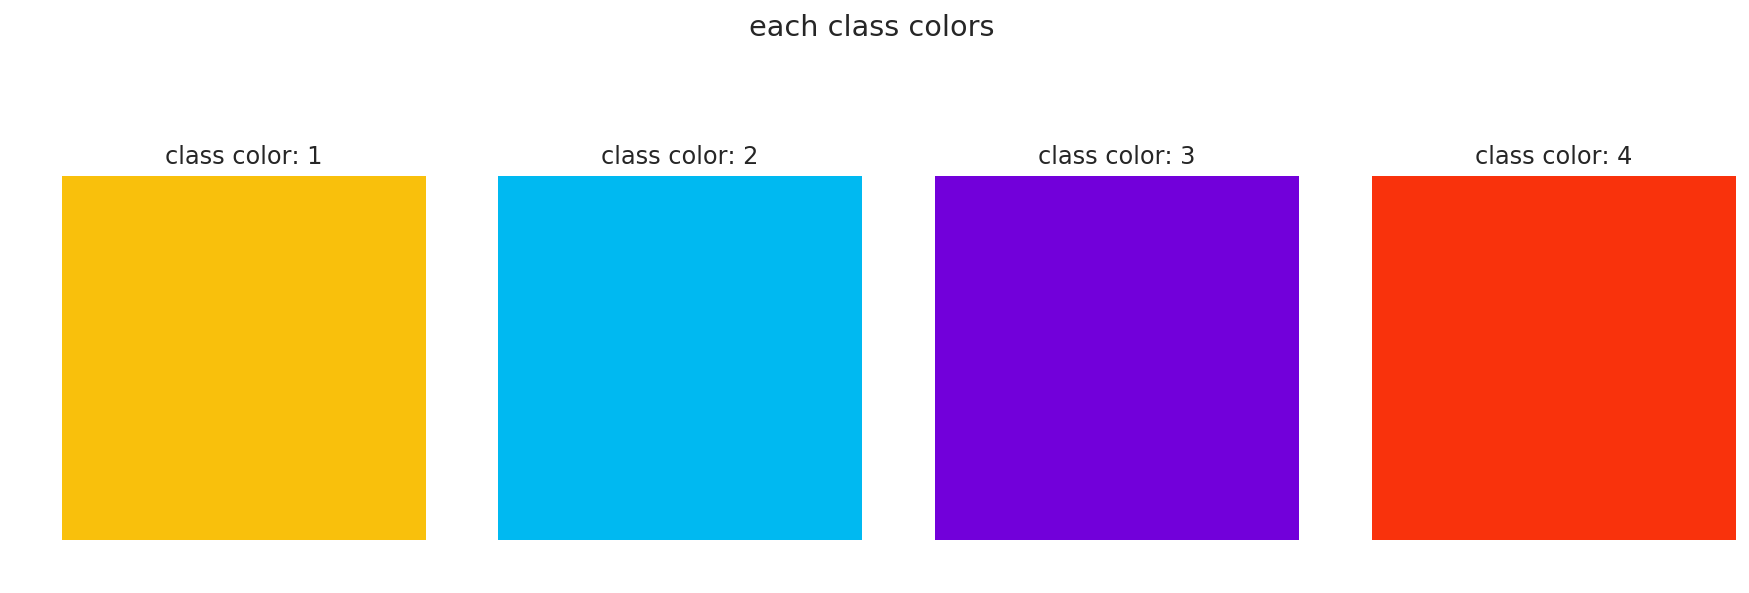

In [34]:
palet = [(249, 192, 12), (0, 185, 241), (114, 0, 218), (249,50,12)]
fig, ax = plt.subplots(1, 4, figsize=(15, 5))
for i in range(4):
    ax[i].axis('off')
    ax[i].imshow(np.ones((50, 50, 3), dtype=np.uint8) * palet[i])
    ax[i].set_title("class color: {}".format(i+1))
fig.suptitle("each class colors")

plt.show()

In [0]:
idx_no_defect = []
idx_class_1 = []
idx_class_2 = []
idx_class_3 = []
idx_class_4 = []
idx_class_multi = []
idx_class_triple = []

for col in range(0, len(train_df), 4):
    img_names = [str(i).split("_")[0] for i in train_df.iloc[col:col+4, 0].values]
    if not (img_names[0] == img_names[1] == img_names[2] == img_names[3]):
        raise ValueError
        
    labels = train_df.iloc[col:col+4, 1]
    if labels.isna().all():
        idx_no_defect.append(col)
    elif (labels.isna() == [False, True, True, True]).all():
        idx_class_1.append(col)
    elif (labels.isna() == [True, False, True, True]).all():
        idx_class_2.append(col)
    elif (labels.isna() == [True, True, False, True]).all():
        idx_class_3.append(col)
    elif (labels.isna() == [True, True, True, False]).all():
        idx_class_4.append(col)
    elif labels.isna().sum() == 1:
        idx_class_triple.append(col)
    else:
        idx_class_multi.append(col)  

In [0]:
# for idx in idx_no_defect[:5]:
#   show_mask(idx)